<b>Target :</b> 

```1. Add Dropout to reduce overfitting```

In [119]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [120]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [121]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [122]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [123]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

def model_summary():
  model = Net().to(device)
  summary(model, input_size=(1, 28, 28))

cuda


In [124]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [125]:
def plot_result():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

In [126]:
class Net(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
      return nn.Sequential(
            nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.02))
        
    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))


    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = self.conv_block(1, 10, 3)
      self.conv2 = self.conv_block(10, 10, 3, 0)
      self.conv3 = self.conv_block(10, 11, 3)
      self.conv4 = self.conv_block(11, 11, 3, 0)
      self.conv5 = self.conv_block(11, 12, 3)
      self.conv6 = self.conv_block(12, 12, 3, 0)
      self.conv7 = self.out_block(12, 3)
      self.pool = nn.MaxPool2d(2, 2)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model_summary() 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 26, 26]             900
              ReLU-6           [-1, 10, 26, 26]               0
       BatchNorm2d-7           [-1, 10, 26, 26]              20
           Dropout-8           [-1, 10, 26, 26]               0
         MaxPool2d-9           [-1, 10, 13, 13]               0
           Conv2d-10           [-1, 11, 13, 13]             990
             ReLU-11           [-1, 11, 13, 13]               0
      BatchNorm2d-12           [-1, 11, 13, 13]              22
          Dropout-13           [-1, 11, 13, 13]               0
           Conv2d-14           [-1, 11,

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10820865631103516 Batch_id=468 Accuracy=94.86: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.031126461923122406 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9885/10000 (98.85%)

EPOCH: 2


Loss=0.03337878733873367 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.012833691202104092 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.023759009316563606 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.010974164120852947 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.013327344320714474 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.004438754171133041 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.020697953179478645 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.008982148952782154 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.02886124886572361 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.07562769949436188 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.007755417376756668 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.006858120206743479 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.01324851717799902 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]



Test set: Average loss: 0.0302, Accuracy: 9915/10000 (99.15%)



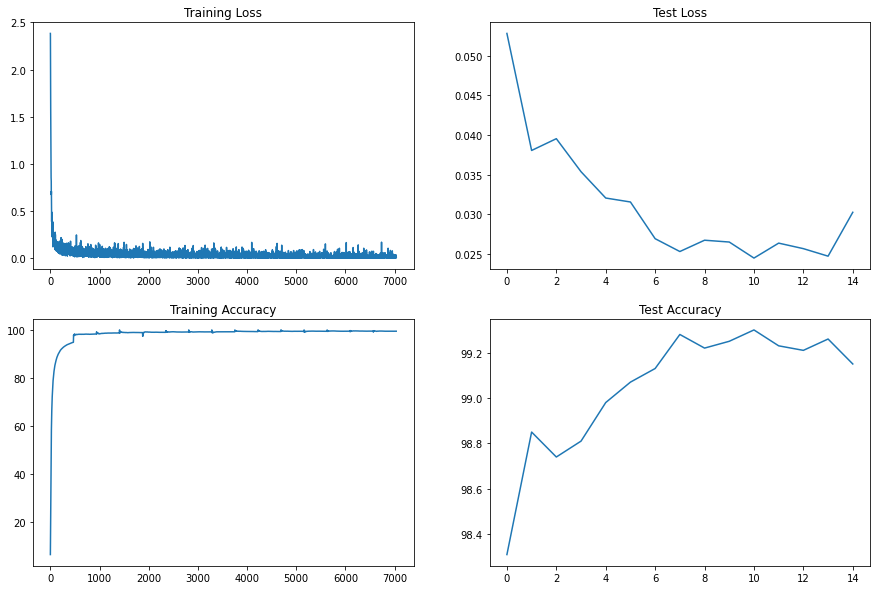

In [127]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

plot_result()

## Results:

<b>Parameters:</b> 6,765

<b>Best Train Accuracy:</b> 99.49

<b>Best Test Accuracy:</b> 99.30

<b>Analysis:</b>
Using dropout have reduce the overfitting but still we are not able to achieve required accuracy, we will next try to implement image augmentation to see if it helps in improving network accuracy 